# Revised Overlappogram

This is another test of the overlappogram pipeline after fixing an issue with the spectral pixel alignment.

In [1]:
import pathlib

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
import aiapy.calibrate
from astropy.wcs.utils import wcs_to_celestial_frame
from astropy.coordinates import SkyCoord
from astropy.visualization import (ImageNormalize,
                                   LogStretch,
                                   AsymmetricPercentileInterval,
                                   quantity_support)
from overlappy.util import color_lat_lon_axes

from mocksipipeline.util import stack_components
from mocksipipeline.physics.dem.data_prep import DataPrep
from mocksipipeline.physics.spectral import SpectralModel, get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response
from mocksipipeline.detector.filter import ThinFilmFilter
from mocksipipeline.detector.component import DetectorComponent, DispersedComponent

## Data

In [2]:
data_dir = pathlib.Path('../pipeline-runs/ar-test')
aia_maps = sunpy.map.Map(list((data_dir / 'AIA').glob('*.fits')))
xrt_maps = sunpy.map.Map(list((data_dir / 'XRT').glob('*.fits')))
ar_time = aia_maps[0].date
map_list = aia_maps + [xrt_maps]

In [3]:
correction_table = aiapy.calibrate.util.get_correction_table() 
pointing_table = aiapy.calibrate.util.get_pointing_table(ar_time-6*u.h, ar_time+6*u.h)
error_table = aiapy.calibrate.util.get_error_table()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [4]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K

In [5]:
dq = DataPrep(
    map_list=aia_maps+[xrt_maps],
    aia_error_table=error_table,
    aia_correction_table=correction_table,
    aia_pointing_table=pointing_table,
    temperature_bin_edges=temperature_bin_edges,
    use_aia_errors=False,
    conserve_flux=True,
    include_cross_calibration=True
)

In [6]:
col = dq.collection

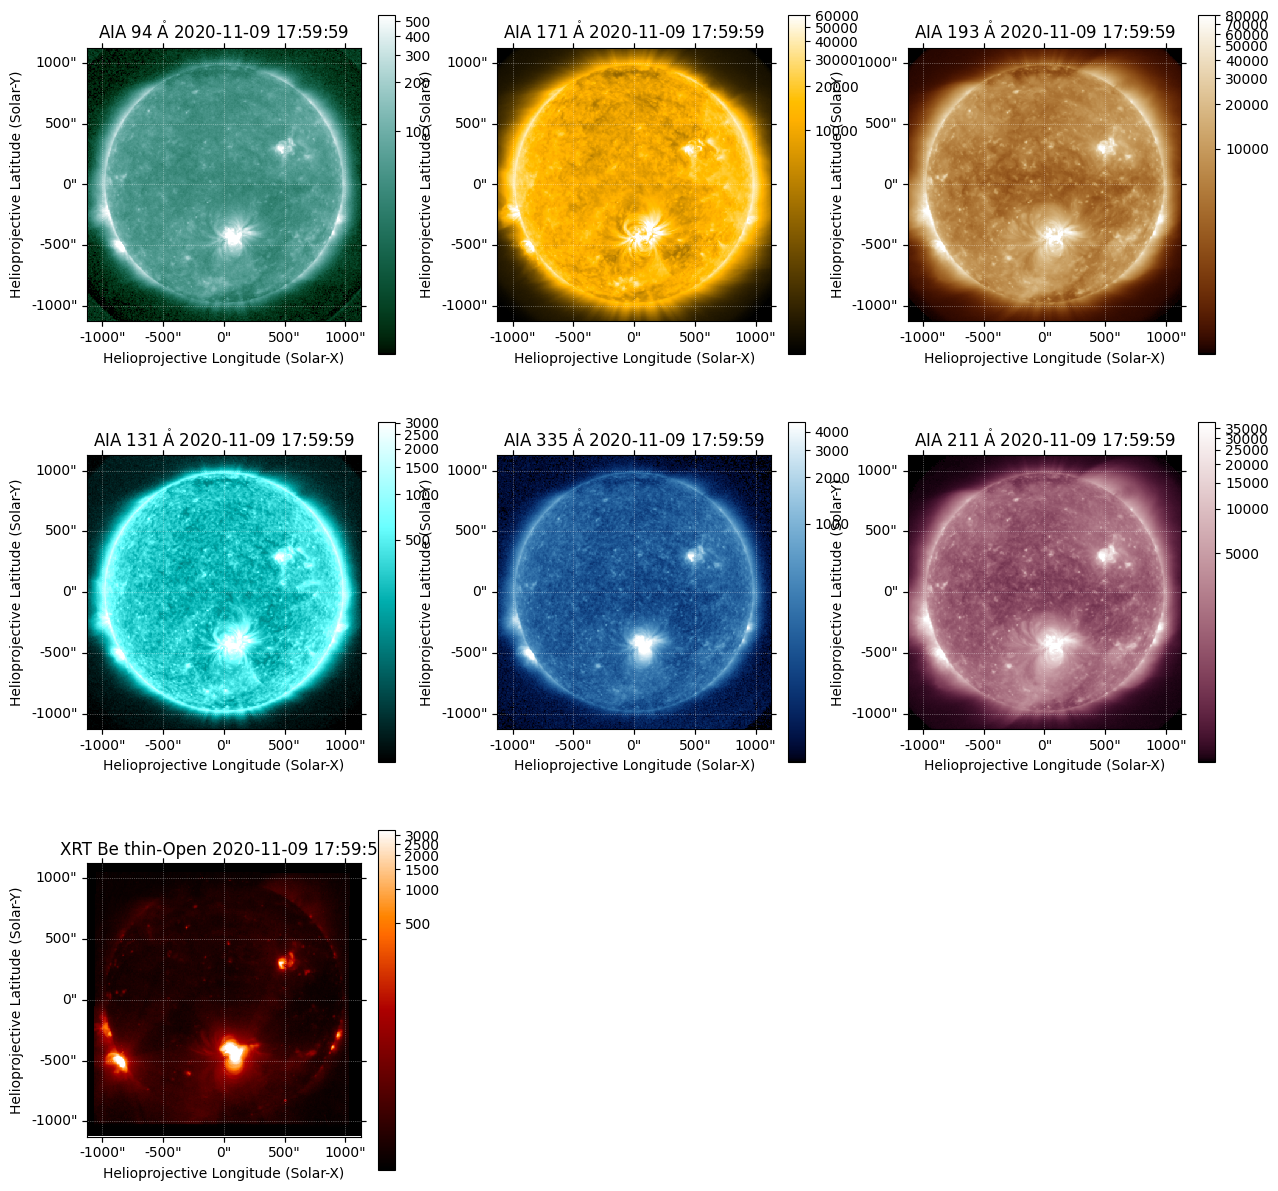

In [7]:
fig = plt.figure(figsize=(15,15))
for i,k in enumerate(col):
    ax = fig.add_subplot(3,3,i+1,projection=col[k])
    m = sunpy.map.Map(col[k].data, col[k].meta)
    if 'AIA' in m.instrument:
        m.plot_settings["cmap"] = f'sdo{m.plot_settings["cmap"]}'
    im = m.plot(axes=ax, clip_interval=(1,99.7)*u.percent)
    fig.colorbar(im)

## DEM

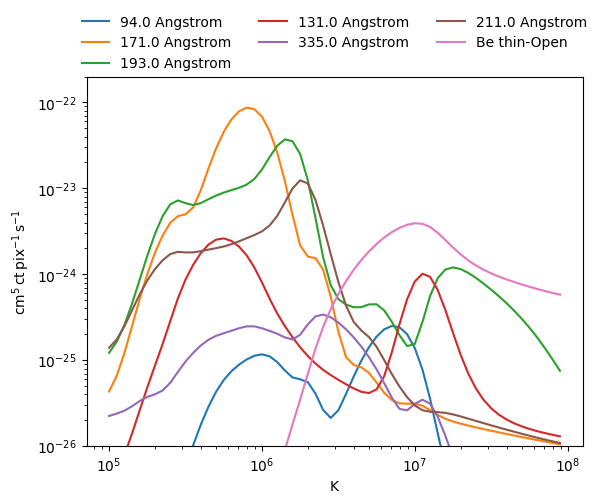

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
with quantity_support():
    for k,v in dq.response_kernels.items():
        ax.plot(dq.kernel_temperatures, v, label=k)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-26,2e-22)
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(.5,1.2), frameon=False)

In [41]:
dem_cube = dq.run(
    max_iterations=10,
    alpha=5.0,
    increase_alpha=1.7,
    use_em_loci=True,
    emd_int=True,
    l_emd=True,
    #nmu=1000,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.02k/2.02k [01:00<00:00, 33.4 x10^2 DEM/s]


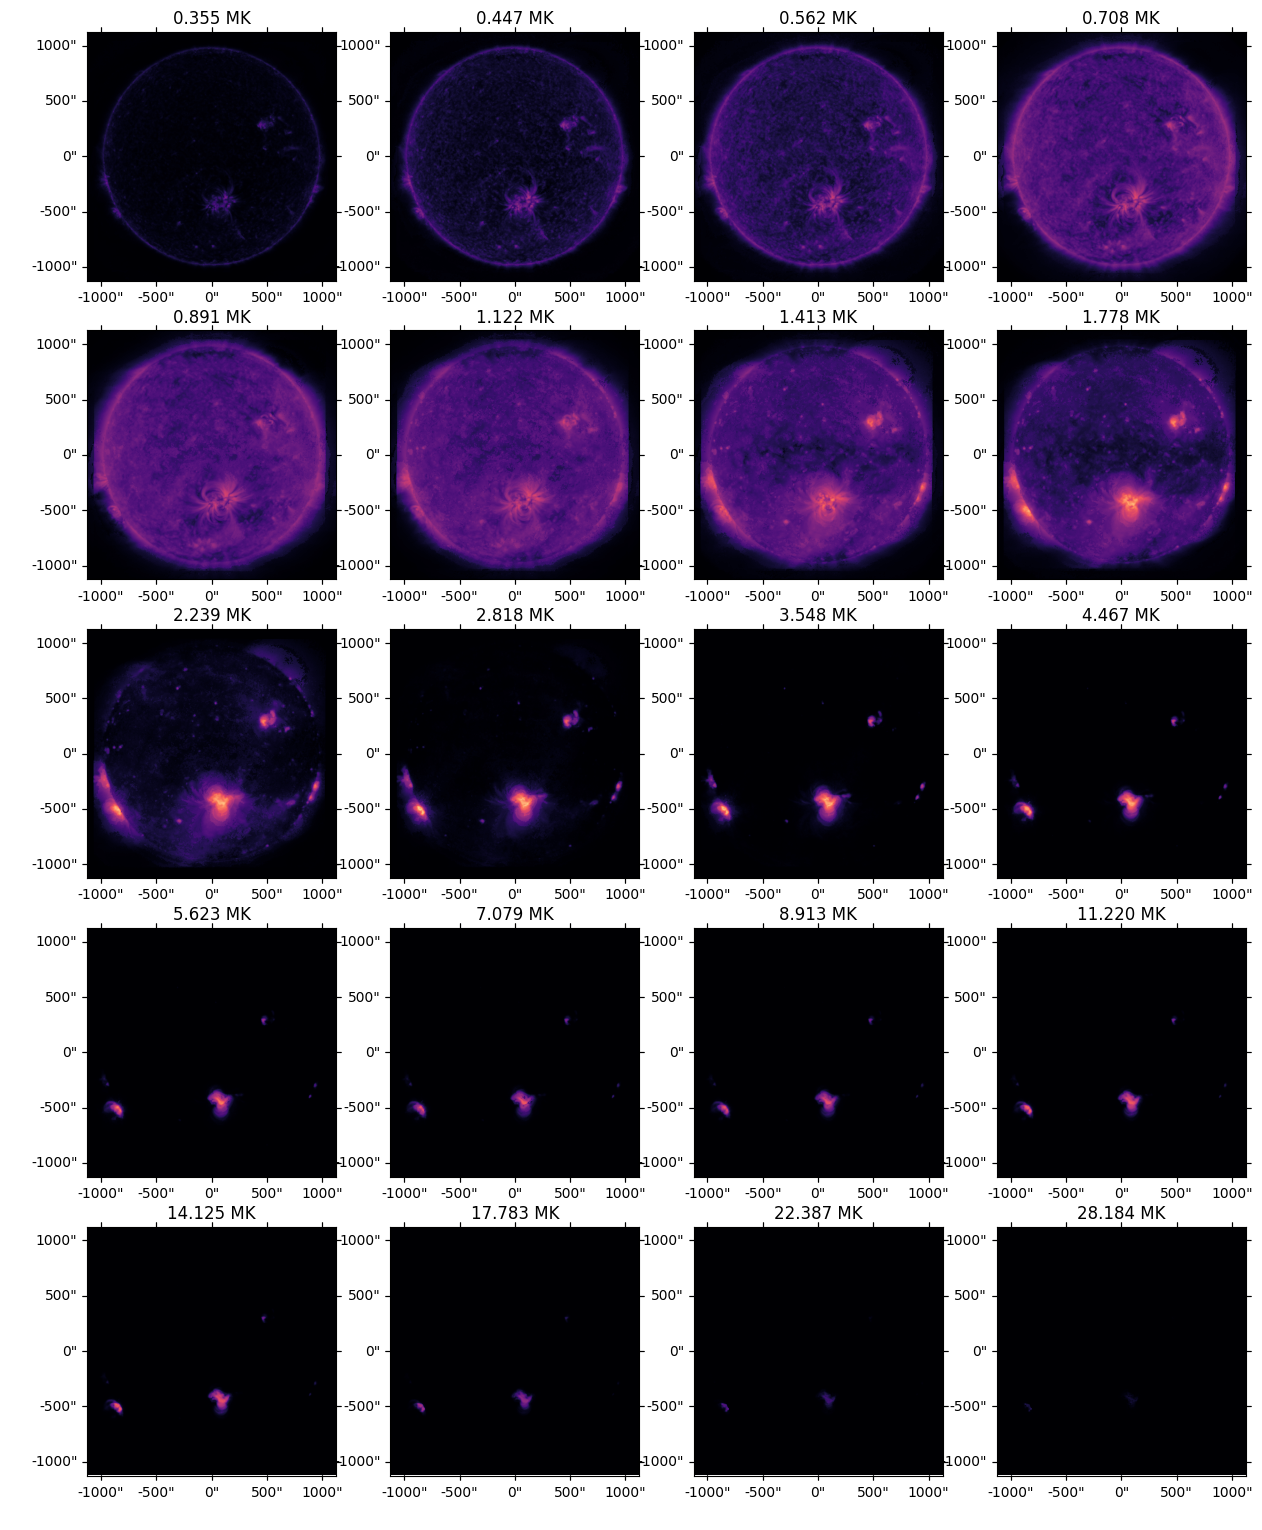

In [16]:
fig = plt.figure(figsize=(15,15*5/4))
for i,cube in enumerate(dem_cube):
    ax = fig.add_subplot(5,4,i+1,projection=cube)
    ax.set_title(f'{dq.temperature_bin_centers[i].to("MK"):.3f}')
    cube.plot(axes=ax,
              norm=ImageNormalize(vmax=1e28,vmin=1e23,stretch=LogStretch()),
              cmap='magma')
    lon,lat = ax.coords
    lon.set_axislabel(' ')
    lat.set_axislabel(' ')

(1e+24, 1e+31)

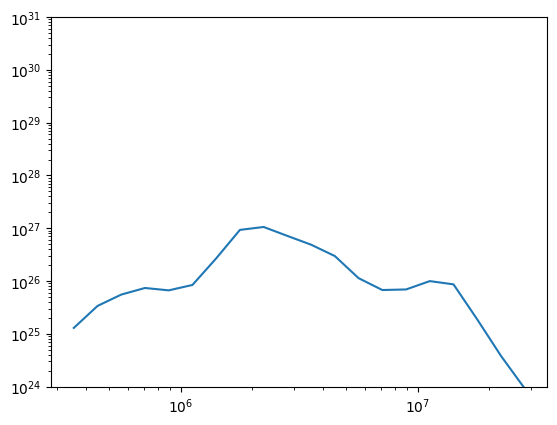

In [17]:
plt.plot(dq.temperature_bin_centers, dem_cube[:,125,250].data)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e24,1e31)

## Spectral Cube

In [18]:
spec_model = SpectralModel()

(0.0, 1270.909090909091)

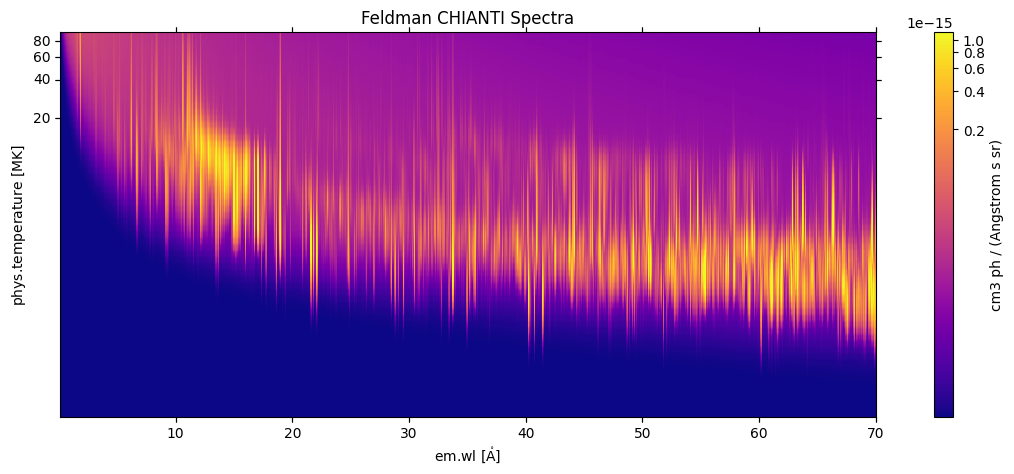

In [19]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=spec_model.spectral_table.wcs)
vmin, vmax = AsymmetricPercentileInterval(1,98).get_limits(
    spec_model.spectral_table.data)
spec_model.spectral_table.plot(axes=ax, aspect=10,
                  axes_units=('MK','Angstrom'),
                  norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
                  cmap='plasma')
fig.colorbar(ax.get_images()[0], label=spec_model.spectral_table.unit)
ax.set_title('Feldman CHIANTI Spectra')
ax.set_xlim(
    spec_model.spectral_table.wcs.world_to_pixel([0.1,70]*u.Angstrom,0*u.MK)[0])

In [20]:
spec_cube = spec_model.run(dem_cube, dq.celestial_wcs)

In [21]:
cube_wave = spec_cube.axis_world_coords(0)[0].to('angstrom')

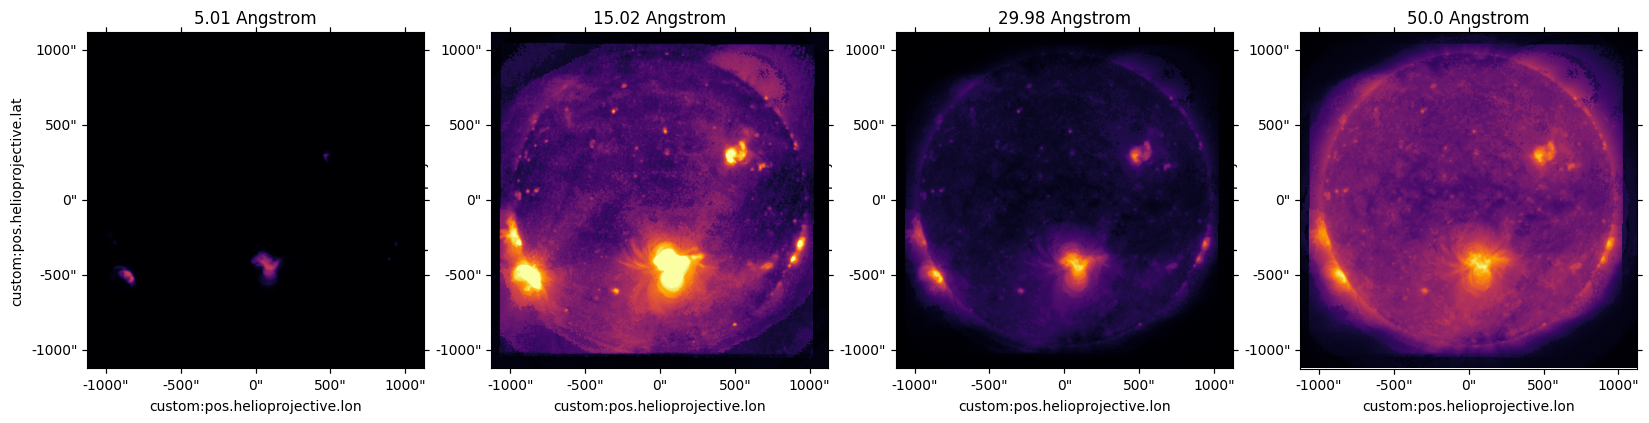

In [22]:
fig = plt.figure(figsize=(20,5))
wave_select = [5.01, 15.02, 29.98, 50] * u.angstrom
norm = ImageNormalize(vmin=0, vmax=1.1e12, stretch=LogStretch())
for i,ws in enumerate(wave_select):
    i_wave = np.argmin(np.fabs(ws - cube_wave))
    cube_slice = spec_cube[i_wave]
    ax = fig.add_subplot(1,4,i+1,projection=cube_slice.wcs)
    cube_slice.plot(axes=ax,norm=norm,cmap="inferno",data_unit='ph /(angstrom cm2 s sr)')
    ax.set_title(ws)

In [37]:
foo = convolve_with_response(
    spec_cube,
    dispersed_channel_o0,
    electrons=False,
)

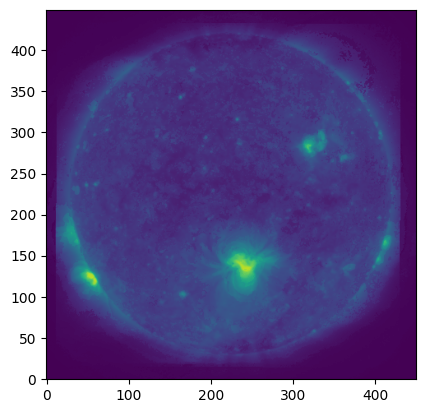

In [40]:
plt.imshow(foo.data[1:].sum(axis=0),origin='lower',
           norm=ImageNormalize(vmin=0,vmax=.1,stretch=LogStretch())
          )

## Overlap

In [23]:
al_thin = ThinFilmFilter(elements='Al', thickness=100*u.nm, xrt_table='Chantler')
dispersed_channel_o0 = SpectrogramChannel(0, [al_thin])
dispersed_channel_o1 = SpectrogramChannel(1,[al_thin])
dispersed_channel_o3 = SpectrogramChannel(3, [al_thin])

In [16]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59721,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:59740,Total threads: 2
Dashboard: http://127.0.0.1:59742/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:59725,


In [17]:
det_disp = DispersedComponent([al_thin],)

In [18]:
overlappograms = det_disp.compute(spec_cube, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *ar

In [24]:
total_overlappogram = stack_components(
    [v for k,v in overlappograms.items()],
    wcs_index=2,
)

In [45]:
hpc_frame = wcs_to_celestial_frame(total_overlappogram.wcs)
endpoints = SkyCoord(Tx=([100,100]*u.arcsec),
                     Ty=([-5600,5600]*u.arcsec),
                     frame=hpc_frame)
lower = SkyCoord(Tx=[275,275]*u.arcsec,
                 Ty=[-650,5600]*u.arcsec,
                 frame=hpc_frame)
upper = SkyCoord(Tx=[-150,-150]*u.arcsec,
                 Ty=[-650,5600]*u.arcsec,frame=hpc_frame)
blc = SkyCoord(Tx=-150*u.arcsec,Ty=-650*u.arcsec,frame=hpc_frame)
trc = SkyCoord(Tx=275*u.arcsec, Ty=5600*u.arcsec,frame=hpc_frame)

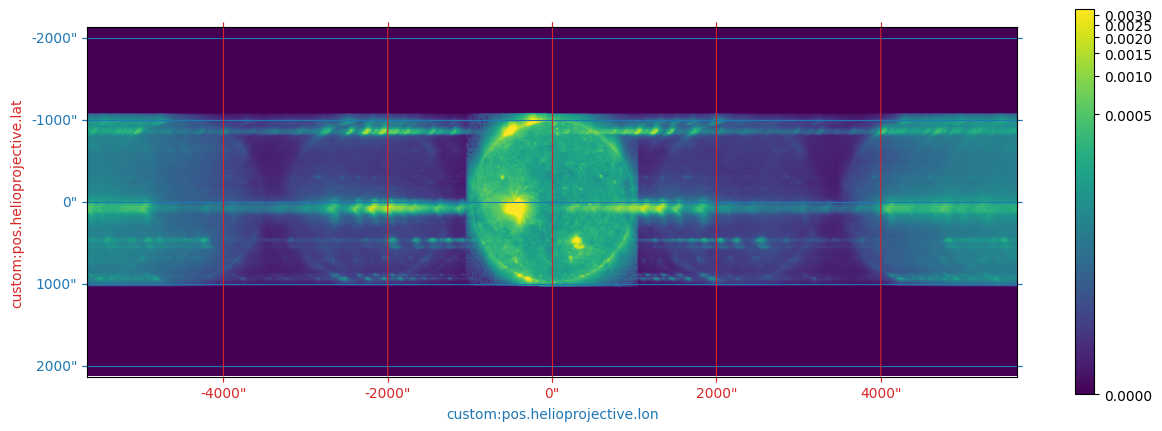

In [38]:
fig = plt.figure(figsize=(15,5))
cropped_cube = total_overlappogram[0,:751,:]
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(cropped_cube.data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()